In [2]:
import os
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from env.EV_Sce_Env import EV_Sce_Env
import math
import seaborn as sns
import numpy as np

env = EV_Sce_Env('SY_2', seed=0)

In [3]:
#哈佛大学Data Science课程CS109推荐的matplotlib 默认设置
#可以方便的设置一次，保证整体风格一致
from matplotlib import rcParams
# #图片大小
# rcParams['figure.figsize'] = (10, 6)
# #图片精度
# rcParams['figure.dpi'] = 150
# #线宽
# rcParams['lines.linewidth'] = 2
#是否显示网格
rcParams['axes.grid'] = True
#axes 填充颜色为浅灰
rcParams['axes.facecolor'] = '#eeeeee'
# #字体大小为14
# rcParams['font.size'] = 14
#边框为无色
rcParams['patch.edgecolor'] = 'none'

In [4]:
methlod = ['OC', 'NGH', 'GH']
sce = ['SY_25']
T1 = 'T1'

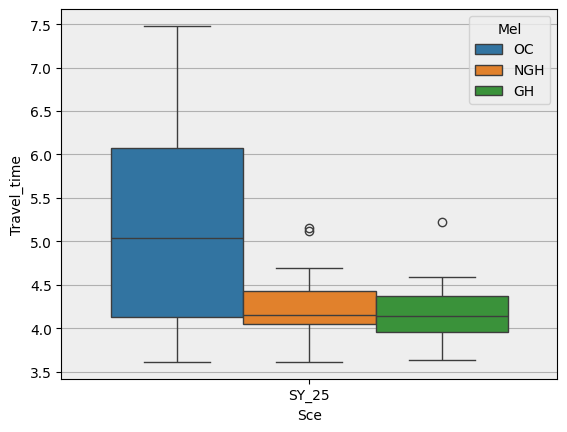

In [5]:
travel_time = pd.DataFrame(columns=['EV', 'Mel', 'Sce', 'Reward', 'Travel_time'])
j = 0
for s in sce:
    for m in methlod:
        df_evg = pd.read_csv('output/{}_{}_{}/EV_g.csv'.format(s, T1, m))
        for i in range(df_evg.shape[0]):
            travel_time.loc[j] = [
                df_evg.iloc[i]['EV'], 
                m, 
                s,
                df_evg.iloc[i]['Reward'],
                df_evg.iloc[i]['Total']
            ]
            j += 1
# ax = sns.boxplot(y="Reward", x="Sce", hue='Mel', data=travel_time)
ax = sns.boxplot(y="Travel_time", x="Sce", hue='Mel', data=travel_time)
plt.savefig('Travel_time.png', dpi=300, bbox_inches='tight')

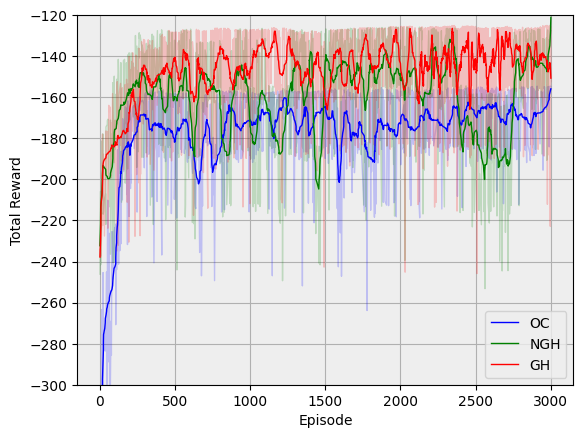

In [6]:
s = 'SY_25'
m_c = {
    'OC': 'blue',
    'NGH': 'green',
    'GH': 'red'
}

df_dic = {}
for m in methlod:
    for f in os.listdir('reward'):
        if m in f.split('_') and s in f:
            df = pd.read_csv('reward/' + f)
            df_dic[m] = df
            
for m in methlod:
    df = df_dic[m]
    plt.plot(df['Step'], df['Value'], c=m_c[m], linewidth=1, alpha=0.2)
for m in methlod:
    df = df_dic[m]
    smooth = scipy.signal.savgol_filter(df['Value'], 51, 5)
    plt.plot(df['Step'], smooth, c=m_c[m], linewidth=1, label=m)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.ylim([-300, -120])
plt.legend(loc='lower right')
# plt.savefig('Total_reward_{}.png'.format(s), dpi=300, bbox_inches='tight')
plt.show()

In [7]:
for m in methlod:
    print(m, 'avg', travel_time.query('Mel=="{}" & Sce=="{}"'.format(m, s))['Travel_time'].mean())
    print(m, 'std', travel_time.query('Mel=="{}" & Sce=="{}"'.format(m, s))['Travel_time'].std())

OC avg 5.160319444444443
OC std 1.1325327774056475
NGH avg 4.2237222222222215
NGH std 0.36023343347949255
GH avg 4.180513888888888
GH std 0.3257755204048995


In [8]:
route_con = {}
route_list = {}
for i in range(env.agent_num):
    ev_id = i
    df_r = pd.read_csv('output/SY_25_T1_GH/EV/EV{}_route.csv'.format(ev_id))
    route = list(df_r['edge'])
    r = route[0]
    for j in range(1, len(route)):
        next_p = route[j].split('-')[-1]
        r += "-"+next_p
    if r not in route_con.keys():
        route_con[r] = 1
        route_list[r] = [ev_id]
    else:
        route_con[r] += 1
        route_list[r].append(ev_id)
GH_route = route_con

route_con = {}
route_list = {}
for i in range(env.agent_num):
    ev_id = i
    df_r = pd.read_csv('output/SY_25_T1_NGH/EV/EV{}_route.csv'.format(ev_id))
    route = list(df_r['edge'])
    r = route[0]
    for j in range(1, len(route)):
        next_p = route[j].split('-')[-1]
        r += "-"+next_p
    if r not in route_con.keys():
        route_con[r] = 1
        route_list[r] = [ev_id]
    else:
        route_con[r] += 1
        route_list[r].append(ev_id)
NGH_route = route_con

In [9]:
route_set = list(set(list(GH_route.keys()) + list(NGH_route.keys())))
df_route = pd.DataFrame(columns=['Route', 'Mel', 'Con'])
i = 0
for j, r in enumerate(route_set):
    df_route.loc[i, 'Route'] = 'Route_' + str(j+1)
    df_route.loc[i, 'Mel'] = 'GH'
    df_route.loc[i, 'Con'] = GH_route[r] if r in GH_route.keys() else 0
    i += 1
    df_route.loc[i, 'Route'] = 'Route_' + str(j+1)
    df_route.loc[i, 'Mel'] = 'NGH'
    df_route.loc[i, 'Con'] = NGH_route[r] if r in NGH_route.keys() else 0
    i += 1

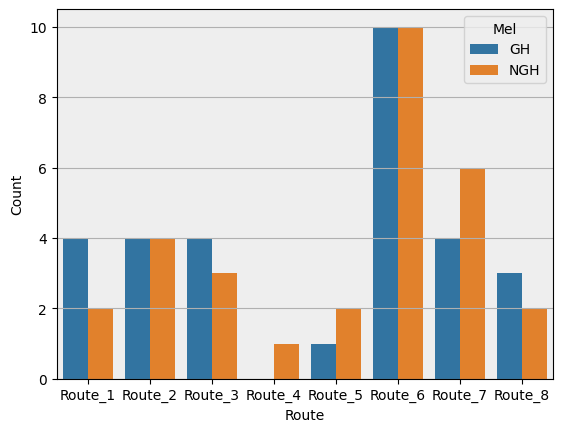

In [10]:
ax = sns.barplot(y="Con", x='Route', hue='Mel', data=df_route, errorbar=('ci', 0))
# ax.set_ylim(0, 1)
ax.set_ylabel('Count')
plt.savefig('Routes.png', dpi=300)
plt.show()

In [11]:
route_set

['0-10-17-18-15-16-19',
 '0-5-6-7-8-9-19',
 '0-5-6-13-14-15-16-19',
 '0-1-2-3-4-19',
 '0-5-6-7-4-19',
 '0-10-11-14-15-16-19',
 '0-10-11-12-7-8-9-19',
 '0-10-11-12-7-4-19']